In [1]:
import sys
print(sys.executable)

/Users/faisal./jupyter_env/bin/python


In [3]:
# core imports and config
import os, json, random, math, shutil
from collections import defaultdict, Counter
from pathlib import Path
from io import BytesIO
from PIL import Image
import requests
from tqdm import tqdm

# ---------- USER CONFIG ----------
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# where COCO annotation files from the zip are located
CAPTIONS_FILE = "captions_val2017.json"
INSTANCES_FILE = "instances_val2017.json"
# optional local image dir if you downloaded val2017.zip
LOCAL_VAL_DIR = None   # or None to always download per-url

# output folders
OUT_ROOT = "coco_datasets"
NEG_DIR = os.path.join(OUT_ROOT, "negation_200")
NUM_DIR = os.path.join(OUT_ROOT, "numeracy_150")
os.makedirs(NEG_DIR, exist_ok=True)
os.makedirs(NUM_DIR, exist_ok=True)

# Keywords: diverse mix of animals, people, furniture, vehicles, small objects
KEYWORDS = [
    "dog", "cat", "person", "car", "bicycle",
    "chair", "cup", "bottle", "book", "backpack",
    "laptop", "umbrella"
]

# Tiers thresholds: area ratio thresholds and allowed other categories
TIERS = {
    "easy": {"min_area_ratio": 0.30, "max_other_cats": 0},
    "medium": {"min_area_ratio": 0.10, "max_other_cats": 1},
    "hard": {"min_area_ratio": 0.01, "max_other_cats": 5}
}

# Dataset size targets
# NEG_TARGET = 200 defined later dw
NUM_TARGET = 150

# Numeracy desired per-count distribution (1..5 where 5 means 5+)
NUM_DESIRED = {1: 30, 2: 40, 3: 30, 4: 20, 5: 30}  # will be scaled to NUM_TARGET
# Allow synthetic crops to reach targets if needed
ALLOW_CROPPING = True
# Maximum relaxation steps (each halves min_area_ratio)
MAX_RELAX = 2
# ---------------------------------


In [4]:
from pycocotools.coco import COCO

assert os.path.exists(CAPTIONS_FILE), f"captions file not found: {CAPTIONS_FILE}"
assert os.path.exists(INSTANCES_FILE), f"instances file not found: {INSTANCES_FILE}"

coco_caps = COCO(CAPTIONS_FILE)
coco_inst = COCO(INSTANCES_FILE)

# helper map: category id -> name, and name->id
catId_to_name = {c['id']: c['name'] for c in coco_inst.loadCats(coco_inst.getCatIds())}
name_to_catId = {v:k for k,v in catId_to_name.items()}
print("COCO categories loaded. Example:", list(catId_to_name.items())[:6])


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
COCO categories loaded. Example: [(1, 'person'), (2, 'bicycle'), (3, 'car'), (4, 'motorcycle'), (5, 'airplane'), (6, 'bus')]


In [5]:
def download_image_by_info(img_info, convert_rgb=True):
    """Download image via coco_url and return PIL.Image."""
    url = img_info.get("coco_url")
    if url is None:
        raise RuntimeError("no coco_url for image")
    r = requests.get(url, timeout=15)
    img = Image.open(BytesIO(r.content))
    if convert_rgb:
        img = img.convert("RGB")
    return img

def get_local_or_download(img_info):
    """Use LOCAL_VAL_DIR if available, else download via URL."""
    fname = img_info['file_name']
    if LOCAL_VAL_DIR and os.path.exists(os.path.join(LOCAL_VAL_DIR, fname)):
        return Image.open(os.path.join(LOCAL_VAL_DIR, fname)).convert("RGB")
    else:
        return download_image_by_info(img_info)

def crop_and_resize_around_bbox(img, bbox, out_size=(512,512), pad_ratio=0.25):
    x,y,w,h = bbox
    cx = x + w/2; cy = y + h/2
    pad_w = w * pad_ratio; pad_h = h * pad_ratio
    left = max(0, int(cx - (w/2 + pad_w)))
    top  = max(0, int(cy - (h/2 + pad_h)))
    right = min(img.width, int(cx + (w/2 + pad_w)))
    bottom = min(img.height, int(cy + (h/2 + pad_h)))
    crop = img.crop((left, top, right, bottom))
    return crop.resize(out_size, Image.LANCZOS)

def save_image_to_folder(img, out_folder, out_name):
    os.makedirs(out_folder, exist_ok=True)
    out_path = os.path.join(out_folder, out_name)
    img.save(out_path)
    return out_path


def get_images_with_category(cat_name):
    """Return list of image dicts (coco image info) that contain at least one instance of cat_name."""
    if cat_name not in name_to_catId:
        print(f"[warn] category {cat_name} not in COCO categories")
        return []
    cid = name_to_catId[cat_name]
    img_ids = coco_inst.getImgIds(catIds=[cid])
    imgs = [coco_inst.loadImgs(i)[0] for i in img_ids]
    return imgs

def image_instances_info(img_id, cat_name=None):
    """Return list of annotations for this image; optionally filter by cat_name."""
    ann_ids = coco_inst.getAnnIds(imgIds=[img_id])
    anns = coco_inst.loadAnns(ann_ids)
    if cat_name:
        cid = name_to_catId.get(cat_name)
        if cid is None:
            return []
        anns = [a for a in anns if a['category_id'] == cid]
    return anns


In [13]:
# helper to evaluate an image candidate for tier constraints
def passes_tier(anns, img_info, tier_cfg, target_cat_id):
    # count other categories
    other_cats = {a['category_id'] for a in anns if a['category_id'] != target_cat_id}
    if len(other_cats) > tier_cfg['max_other_cats']:
        return False
    img_area = img_info['width'] * img_info['height']
    target_area = sum(a.get('area',0) for a in anns if a['category_id'] == target_cat_id)
    area_ratio = target_area / img_area if img_area>0 else 0
    return area_ratio >= tier_cfg['min_area_ratio']

def build_negation_dataset(keywords, tiers, neg_target=100, allow_cropping=True, max_relax=2):
    per_keyword_target = max(1, neg_target // len(keywords))  # rough allocation
    print("Per-keyword approx target:", per_keyword_target)
    metadata = []
    used_img_ids = set()

    for kw in keywords:
        print(f"\nCollecting for keyword: {kw}")
        if kw not in name_to_catId:
            print("  [skip] not a COCO category")
            continue
        cid = name_to_catId[kw]
        imgs = get_images_with_category(kw)
        random.shuffle(imgs)

        # for each tier, attempt collection with relaxation
        for tier_name, cfg in tiers.items():
            collected = 0
            relax = 0
            needed = int(round(per_keyword_target * (0.30 if tier_name=='easy' else 0.40 if tier_name=='medium' else 0.30)))
            # loop relax steps
            while collected < needed and relax <= max_relax:
                cur_cfg = dict(cfg)
                cur_cfg['min_area_ratio'] = cfg['min_area_ratio'] / (2**relax)
                cur_cfg['max_other_cats'] = cfg['max_other_cats'] + relax
                # scan images
                for img in imgs:
                    if collected >= needed:
                        break
                    if img['id'] in used_img_ids:
                        continue
                    anns = image_instances_info(img['id'])  # all anns
                    if not anns:
                        continue
                    if not passes_tier(anns, img, cur_cfg, cid):
                        continue
                    # pass -> collect
                    # capture target anns only for counts etc
                    target_anns = [a for a in anns if a['category_id']==cid]
                    img_area = img['width']*img['height']
                    total_target_area = sum(a.get('area',0) for a in target_anns)
                    area_ratio = total_target_area / img_area if img_area>0 else 0.0
                    # prepare metadata entry
                    file_name = img['file_name']
                    entry = {
                        "image_id": img['id'],
                        "file_name": file_name,
                        "keyword": kw,
                        "tier": tier_name,
                        "synthetic": False,
                        "num_instances": len(target_anns),
                        "total_target_area": total_target_area,
                        "img_area": img_area,
                        "area_ratio": area_ratio,
                        "other_categories_present": list({a['category_id'] for a in anns if a['category_id']!=cid}),
                        "captions": [a['caption'] for a in coco_caps.loadAnns(coco_caps.getAnnIds(imgIds=[img['id']]))]
                    }
                    metadata.append(entry)
                    used_img_ids.add(img['id'])
                    collected += 1
                relax += 1

            # if still short and cropping allowed, create synthetic crops from images that have the object
            if allow_cropping and collected < needed:
                print(f"   need {needed-collected} synthetic crops for {kw}/{tier_name}")
                # consider remaining images (not used) that have the object
                candidate_ids = [im['id'] for im in imgs if im['id'] not in used_img_ids]
                for img_id in candidate_ids:
                    if collected >= needed:
                        break
                    img_info = coco_inst.loadImgs([img_id])[0]
                    anns = image_instances_info(img_id, kw)
                    if not anns:
                        continue
                    # pick largest bbox
                    anns = sorted(anns, key=lambda a: a.get('area',0), reverse=True)
                    bbox = anns[0]['bbox']
                    try:
                        img_pil = get_local_or_download(img_info)
                        crop = crop_and_resize_around_bbox(img_pil, bbox, out_size=(512,512), pad_ratio=0.25)
                        # save cropped image with new name
                        new_name = f"{img_id}_crop_{kw}_{tier_name}.jpg"
                        save_image_to_folder(crop, NEG_DIR, new_name)
                        # create entry and mark synthetic
                        entry = {
                            "image_id": img_id,
                            "file_name": new_name,
                            "keyword": kw,
                            "tier": tier_name,
                            "synthetic": True,
                            "num_instances": len(anns),
                            "total_target_area": anns[0].get('area',0),
                            "img_area": crop.width*crop.height,
                            "area_ratio": 1.0,
                            "other_categories_present": [],
                            "captions": [a['caption'] for a in coco_caps.loadAnns(coco_caps.getAnnIds(imgIds=[img_id]))],
                            "creation_note": "cropped_to_make_object_dominant"
                        }
                        metadata.append(entry)
                        used_img_ids.add(img_id)  # avoid reuse
                        collected += 1
                    except Exception as e:
                        # skip if download or crop fails
                        continue

            print(f"  collected for {kw}/{tier_name}: {collected}/{needed}")

    # after all keywords aggregated, if more than NEG_TARGET trim, else if less, fill from remaining pool
    if len(metadata) > neg_target:
        random.shuffle(metadata)
        metadata = metadata[:neg_target]
    elif len(metadata) < neg_target:
        # fill from other images that have any of the keywords, preferring medium/hard
        print("Filling shortage from remaining pool...")
        all_candidate_imgs = []
        for kw in keywords:
            for img in get_images_with_category(kw):
                if img['id'] in used_img_ids: continue
                all_candidate_imgs.append(img)
        random.shuffle(all_candidate_imgs)
        for img in all_candidate_imgs:
            if len(metadata) >= neg_target:
                break
            img_info = img
            # choose kw by intersection with keywords present in annotations
            anns = image_instances_info(img_info['id'])
            present_keywords = [catId_to_name[a['category_id']] for a in anns if catId_to_name[a['category_id']] in keywords]
            if not present_keywords: continue
            kw_use = present_keywords[0]
            cid = name_to_catId[kw_use]
            target_anns = [a for a in anns if a['category_id']==cid]
            entry = {
                "image_id": img_info['id'],
                "file_name": img_info['file_name'],
                "keyword": kw_use,
                "tier": "hard",  # fallback
                "synthetic": False,
                "num_instances": len(target_anns),
                "total_target_area": sum(a.get('area',0) for a in target_anns),
                "img_area": img_info['width']*img_info['height'],
                "area_ratio": sum(a.get('area',0) for a in target_anns) / (img_info['width']*img_info['height']),
                "other_categories_present": list({a['category_id'] for a in anns if a['category_id']!=cid}),
                "captions": [a['caption'] for a in coco_caps.loadAnns(coco_caps.getAnnIds(imgIds=[img_info['id']]))]
            }
            metadata.append(entry)
            used_img_ids.add(img_info['id'])

    # save images for non-synthetic entries into NEG_DIR if not already saved
    # we prefer to copy existing file if LOCAL_VAL_DIR is present, else download lazily later
    copied = 0
    for entry in metadata:
        if entry['synthetic']:
            continue  # already saved
        src_name = entry['file_name']
        # if local images exist, copy from LOCAL_VAL_DIR/filename -> NEG_DIR
        if LOCAL_VAL_DIR and os.path.exists(os.path.join(LOCAL_VAL_DIR, src_name)):
            shutil.copy2(os.path.join(LOCAL_VAL_DIR, src_name), os.path.join(NEG_DIR, src_name))
            copied += 1
        else:
            # download and save into NEG_DIR
            img_info = coco_inst.loadImgs([entry['image_id']])[0]
            try:
                img = download_image_by_info(img_info)
                img.save(os.path.join(NEG_DIR, src_name))
                copied += 1
            except Exception:
                pass

    # finally add templated captions (can be replaced with LLM later)
    for e in metadata:
        kw = e['keyword']
        e['correct_caption'] = f"There is a {kw} in the image."
        e['negated_caption'] = f"There is not a {kw} in the image."
        e['task'] = 'negation'

    print(f"\n'Present Object' dataset part built: {len(metadata)} items.")
    return metadata, used_img_ids


In [15]:
import os
import shutil
import random
import json

def build_absent_object_dataset(KEYWORDS, target_absent_count, used_img_ids):
    """
    Builds a dataset of images that *do not* contain the target keywords.
    Fills to target_absent_count.
    Relies on global vars: KEYWORDS, coco_inst, coco_caps, name_to_catId, 
                             NEG_DIR, LOCAL_VAL_DIR.
    Assumes helper 'download_image_by_info' exists.
    """
    print("\n--- Building Absent Object Dataset ---")
    metadata = []
    # Calculate target per keyword
    per_keyword_target = max(1, target_absent_count // len(KEYWORDS))
    print(f"Per-keyword approx target (absent): {per_keyword_target}")

    all_img_ids = set(coco_inst.getImgIds())
    
    for kw in KEYWORDS:
        print(f"\nCollecting 'absent' images for keyword: {kw}")
        if kw not in name_to_catId:
            print(f"  [skip] '{kw}' not a COCO category")
            continue
            
        cid = name_to_catId[kw]
        
        # 1. Get all image IDs that *contain* the keyword
        img_ids_with_kw = set(coco_inst.getImgIds(catIds=[cid]))
        
        # 2. Get candidate pool:
        #    (All IDs) - (IDs WITH keyword) - (IDs ALREADY USED)
        candidate_img_ids = (all_img_ids - img_ids_with_kw) - used_img_ids
        
        if not candidate_img_ids:
            print(f"  [skip] No unused images found that lack '{kw}'")
            continue

        candidate_img_ids = list(candidate_img_ids)
        random.shuffle(candidate_img_ids)
        
        collected = 0
        for img_id in candidate_img_ids:
            if collected >= per_keyword_target:
                break
                
            img_info = coco_inst.loadImgs([img_id])[0]
            
            # Ensure the image is not empty
            ann_ids = coco_inst.getAnnIds(imgIds=[img_id])
            if not ann_ids:
                continue
                
            # --- File Handling (Copy/Download) ---
            src_name = img_info['file_name']
            dest_path = os.path.join(NEG_DIR, src_name)
            
            if not os.path.exists(dest_path):
                if LOCAL_VAL_DIR and os.path.exists(os.path.join(LOCAL_VAL_DIR, src_name)):
                    shutil.copy2(os.path.join(LOCAL_VAL_DIR, src_name), dest_path)
                else:
                    try:
                        img = download_image_by_info(img_info) 
                        img.save(dest_path)
                    except Exception as e:
                        print(f"  [skip] Failed to download {src_name}: {e}")
                        continue
            
            # --- Create Metadata Entry ---
            present_anns = coco_inst.loadAnns(ann_ids)
            present_cat_ids = list({a['category_id'] for a in present_anns})
            
            entry = {
                "image_id": img_info['id'],
                "file_name": img_info['file_name'],
                "keyword": kw,  # The keyword that is *absent*
                "tier": "absent",
                "synthetic": False,
                "num_instances": 0,
                "total_target_area": 0,
                "img_area": img_info['width'] * img_info['height'],
                "area_ratio": 0.0,
                "other_categories_present": present_cat_ids,
                "captions": [a['caption'] for a in coco_caps.loadAnns(coco_caps.getAnnIds(imgIds=[img_id]))],
                "creation_note": f"image does not contain {kw}"
            }
            
            entry['correct_caption'] = f"There is not a {kw} in the image."
            entry['negated_caption'] = f"There is a {kw} in the image."
            entry['task'] = 'negation_absent' 

            metadata.append(entry)
            used_img_ids.add(img_id) 
            collected += 1
            
        print(f"  collected for {kw}/absent: {collected}/{per_keyword_target}")

    # --- NEW: Fill Shortage Logic ---
    if len(metadata) < target_absent_count:
        print(f"Filling shortage for absent objects... (Need {target_absent_count - len(metadata)} more)")
        
        # Create a pool of all images that don't have *any* of our keywords
        # This is a good "general purpose" pool of absent images
        all_keyword_cat_ids = {name_to_catId[kw] for kw in KEYWORDS if kw in name_to_catId}
        all_img_ids_with_any_keyword = set(coco_inst.getImgIds(catIds=list(all_keyword_cat_ids)))
        
        # Pool = (All IDs) - (IDs with *any* keyword) - (IDs already used)
        candidate_pool = list((all_img_ids - all_img_ids_with_any_keyword) - used_img_ids)
        random.shuffle(candidate_pool)
        
        if not candidate_pool:
            print("  [Warning] No more 'keyword-free' images left to fill shortage.")

        for img_id in candidate_pool:
            if len(metadata) >= target_absent_count:
                break # We're full!
                
            # Pick a random keyword to be "absent" for this image
            # We know none of our keywords are in it, so any is fine
            kw_use = random.choice(KEYWORDS)
            img_info = coco_inst.loadImgs([img_id])[0]
            
            # --- File Handling (Copy/Download) ---
            src_name = img_info['file_name']
            dest_path = os.path.join(NEG_DIR, src_name)
            
            if not os.path.exists(dest_path):
                if LOCAL_VAL_DIR and os.path.exists(os.path.join(LOCAL_VAL_DIR, src_name)):
                    shutil.copy2(os.path.join(LOCAL_VAL_DIR, src_name), dest_path)
                else:
                    try:
                        img = download_image_by_info(img_info) 
                        img.save(dest_path)
                    except Exception as e:
                        print(f"  [skip] Failed to download {src_name}: {e}")
                        continue
            
            # --- Create Metadata Entry ---
            ann_ids = coco_inst.getAnnIds(imgIds=[img_id])
            present_cat_ids = []
            captions_data = []
            if ann_ids: # Image might have annotations for keywords we don't care about
                present_anns = coco_inst.loadAnns(ann_ids)
                present_cat_ids = list({a['category_id'] for a in present_anns})
                captions_data = [a['caption'] for a in coco_caps.loadAnns(coco_caps.getAnnIds(imgIds=[img_id]))]

            entry = {
                "image_id": img_info['id'],
                "file_name": img_info['file_name'],
                "keyword": kw_use, # The randomly chosen absent keyword
                "tier": "absent_fill", # Mark as from the fill-in pool
                "synthetic": False,
                "num_instances": 0,
                "total_target_area": 0,
                "img_area": img_info['width'] * img_info['height'],
                "area_ratio": 0.0,
                "other_categories_present": present_cat_ids,
                "captions": captions_data,
                "creation_note": f"image does not contain {kw_use} (from fill pool)"
            }
            
            entry['correct_caption'] = f"There is not a {kw_use} in the image."
            entry['negated_caption'] = f"There is a {kw_use} in the image."
            entry['task'] = 'negation_absent' 

            metadata.append(entry)
            used_img_ids.add(img_id)

    # --- End of Fill Shortage Logic ---

    print(f"\n'Absent Object' dataset part built: {len(metadata)} items.")
    return metadata, used_img_ids

In [16]:
TARGET_PRESENT = 100
TARGET_ABSENT = 100

print("===== STARTING: Building PRESENT Object Dataset =====")

present_metadata, used_ids = build_negation_dataset(KEYWORDS, TIERS, neg_target=TARGET_PRESENT, allow_cropping=ALLOW_CROPPING, max_relax=MAX_RELAX)
print(f"\nTotal images used so far: {len(used_ids)}")

print("\n===== STARTING: Building ABSENT Object Dataset =====")
absent_metadata, final_used_ids = build_absent_object_dataset(
    KEYWORDS, 
    target_absent_count=TARGET_ABSENT,
    used_img_ids=used_ids 
)

print(f"\nTotal images used in total: {len(final_used_ids)}")

# --- Combine and Save Final Dataset ---
full_metadata = present_metadata + absent_metadata
random.shuffle(full_metadata)

# Save to the *original* filename you wanted
final_meta_path = os.path.join(NEG_DIR, "negation_metadata.json")

with open(final_meta_path, "w") as f:
    json.dump(full_metadata, f, indent=2)

print(f"\n--- DONE ---")
print(f"Total items in final dataset: {len(full_metadata)}")
print(f"  Present objects: {len(present_metadata)}")
print(f"  Absent objects: {len(absent_metadata)}")
print(f"Final combined metadata saved to: {final_meta_path}")

===== STARTING: Building PRESENT Object Dataset =====
Per-keyword approx target: 8

  collected for dog/easy: 2/2
  collected for dog/medium: 3/3
  collected for dog/hard: 2/2

  collected for cat/easy: 2/2
  collected for cat/medium: 3/3
  collected for cat/hard: 2/2

  collected for person/easy: 2/2
  collected for person/medium: 3/3
  collected for person/hard: 2/2

  collected for car/easy: 2/2
  collected for car/medium: 3/3
  collected for car/hard: 2/2

  collected for bicycle/easy: 2/2
  collected for bicycle/medium: 3/3
  collected for bicycle/hard: 2/2

  collected for chair/easy: 2/2
  collected for chair/medium: 3/3
  collected for chair/hard: 2/2

  collected for cup/easy: 2/2
  collected for cup/medium: 3/3
  collected for cup/hard: 2/2

  collected for bottle/easy: 2/2
  collected for bottle/medium: 3/3
  collected for bottle/hard: 2/2

  collected for book/easy: 2/2
  collected for book/medium: 3/3
  collected for book/hard: 2/2

  collected for backpack/easy: 2/2
  col

In [12]:
def pluralize(word, n):
    if n == 1:
        return word
    if word.endswith(('s','x','z','ch','sh')):
        return word + 'es'
    if word.endswith('y') and (len(word)>1 and word[-2] not in 'aeiou'):
        return word[:-1] + 'ies'
    return word + 's'

def make_count_caption(n, keyword):
    if n == 0:
        return f"There are no {pluralize(keyword,2)} in the image."
    if n == 1:
        return f"There is 1 {keyword} in the image."
    return f"There are {n} {pluralize(keyword,n)} in the image."

def build_numeracy_dataset_from_scratch(keywords, num_target=150, num_desired=None, allow_download=True):
    """
    Build numeracy dataset reproducibly from COCO val annotations.
    - keywords: list of target class names (must be COCO categories)
    - num_target: desired total number of numeracy items
    - num_desired: dict {1:count,2:count,...,5:count} distribution to scale to num_target
    Returns: list of metadata entries and writes numeracy_metadata_fixed.json in NUM_DIR.
    """
    if num_desired is None:
        num_desired = {1:1,2:1,3:1,4:1,5:1}
    # scale distribution to num_target
    s = sum(num_desired.values())
    desired = {k: max(1, int(round(v * (num_target / s)))) for k,v in num_desired.items()}
    # adjust rounding to exactly num_target
    cur_sum = sum(desired.values())
    # fix difference by adding/subtracting 1 from largest buckets
    while cur_sum != num_target:
        if cur_sum < num_target:
            # add 1 to the bucket with currently largest desired (prefer higher counts)
            k = max(desired.keys())
            desired[k] += 1
            cur_sum += 1
        else:
            k = max(desired.keys())
            if desired[k] > 1:
                desired[k] -= 1
                cur_sum -=1
            else:
                # fallback: break
                break
    print("Desired per-count (1..5 where 5 = 5+):", desired)

    # Build candidate pool: for each image in COCO val that contains any of our KEYWORDS,
    # compute counts per keyword and choose the dominant keyword (highest count among KEYWORDS).
    print("Scanning COCO for candidate images (this may take ~1-2 min)...")
    all_img_ids = set()
    for kw in keywords:
        cid = name_to_catId.get(kw)
        if cid is None:
            print(f"[warn] {kw} not found in COCO categories, skipping.")
            continue
        ids = coco_inst.getImgIds(catIds=[cid])
        all_img_ids.update(ids)
    all_img_ids = list(all_img_ids)
    random.shuffle(all_img_ids)

    # candidate entries: image_info, dominant_keyword, dominant_count
    candidates = []
    for img_id in all_img_ids:
        anns = image_instances_info(img_id)
        # count occurrences per keyword
        counts = {}
        for a in anns:
            cat_name = catId_to_name.get(a['category_id'])
            if cat_name in keywords:
                counts[cat_name] = counts.get(cat_name, 0) + 1
        if not counts:
            continue
        # choose dominant keyword (max count); tie-break by arbitrary order
        dom_kw, dom_count = max(counts.items(), key=lambda kv: (kv[1], kv[0]))
        img_info = coco_inst.loadImgs([img_id])[0]
        candidates.append((img_info, dom_kw, dom_count))

    print("Total candidate images containing keywords:", len(candidates))

    # bucket by count (clip 5+ to 5)
    buckets = defaultdict(list)
    for img_info, kw, cnt in candidates:
        key = 5 if cnt >= 5 else cnt
        buckets[key].append((img_info, kw, cnt))

    # sample from buckets per desired distribution
    selected = []
    for cnt_bucket, want in desired.items():
        pool = buckets.get(cnt_bucket, [])
        take = min(len(pool), want)
        if take > 0:
            selected.extend(random.sample(pool, take))

    # If shortage, try to fill from other buckets (prefer higher counts)
    if len(selected) < num_target:
        remaining = []
        for k in sorted(buckets.keys(), reverse=True):  # higher counts first
            remaining.extend([t for t in buckets[k] if t not in selected])
        needed = num_target - len(selected)
        selected.extend(remaining[:needed])

    print("Selected images:", len(selected))

    # build metadata entries and download images
    metadata = []
    for img_info, kw, cnt in selected:
        img_id = img_info['id']
        fname = img_info['file_name']
        # download (or copy if LOCAL_VAL_DIR is set)
        out_path = os.path.join(NUM_DIR, fname)
        if LOCAL_VAL_DIR and os.path.exists(os.path.join(LOCAL_VAL_DIR, fname)):
            shutil.copy2(os.path.join(LOCAL_VAL_DIR, fname), out_path)
        else:
            try:
                img = download_image_by_info(img_info)
                img.save(out_path)
            except Exception as e:
                print("Download failed for", img_id, "skipping", e)
                continue

        # create explicit captions (use dominant kw)
        correct = make_count_caption(cnt, kw)
        foils = []
        if cnt-1 >= 0:
            foils.append(make_count_caption(max(0, cnt-1), kw))
        foils.append(make_count_caption(cnt+1, kw))

        meta = {
            "image_id": img_id,
            "file_name": fname,
            "keyword": kw,
            "num_instances": cnt,
            "count_bucket": 5 if cnt>=5 else cnt,
            "captions": [a['caption'] for a in coco_caps.loadAnns(coco_caps.getAnnIds(imgIds=[img_id]))],
            "correct_caption": correct,
            "foils": foils,
            "task": "numeracy",
            "synthetic": False
        }
        metadata.append(meta)

    # trim to exact num_target (in case downloads omitted some)
    if len(metadata) > num_target:
        metadata = random.sample(metadata, num_target)

    # final save
    out_json = os.path.join(NUM_DIR, "numeracy_metadata_fixed.json")
    with open(out_json, "w") as f:
        json.dump(metadata, f, indent=2)
    print("Saved numeracy metadata to", out_json, "   total items:", len(metadata))
    return metadata




In [16]:
# Run builder
num_meta = build_numeracy_dataset_from_scratch(KEYWORDS, num_target=150, num_desired=NUM_DESIRED)

Desired per-count (1..5 where 5 = 5+): {1: 30, 2: 40, 3: 30, 4: 20, 5: 30}
Scanning COCO for candidate images (this may take ~1-2 min)...
Total candidate images containing keywords: 3588
Selected images: 150
Saved numeracy metadata to coco_datasets/numeracy_150/numeracy_metadata_fixed.json    total items: 150


Total items: 200
By keyword (top): [('person', 21), ('chair', 19), ('cat', 18), ('car', 17), ('backpack', 16), ('dog', 16), ('book', 16), ('bicycle', 16), ('bottle', 16), ('umbrella', 15)]
By tier: {'absent': 96, 'medium': 36, 'easy': 24, 'hard': 40, 'absent_fill': 4}
Synthetic crops: 0
Total items: 150
By keyword (top): [('person', 94), ('car', 17), ('cup', 10), ('chair', 9), ('cat', 5), ('bottle', 5), ('dog', 4), ('laptop', 3), ('book', 2), ('umbrella', 1)]
By tier: {}
Synthetic crops: 0

Negation samples:


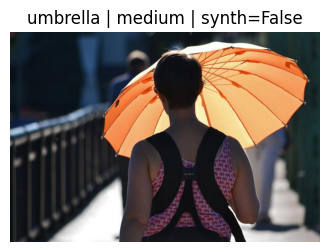

Correct: There is a umbrella in the image.
Negated: There is not a umbrella in the image.
----------------------------------------

Numeracy samples:


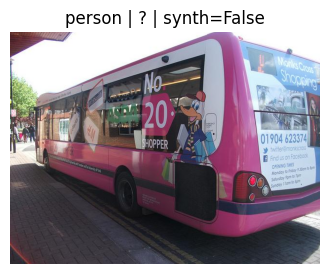

Correct: There are 4 persons in the image.
Foils: There are 3 persons in the image.
There are 5 persons in the image.
----------------------------------------


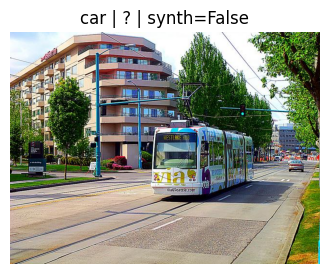

Correct: There are 3 cars in the image.
Foils: There are 2 cars in the image.
There are 4 cars in the image.
----------------------------------------


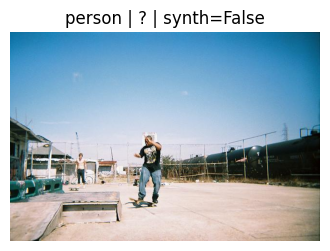

Correct: There are 2 persons in the image.
Foils: There is 1 person in the image.
There are 3 persons in the image.
----------------------------------------


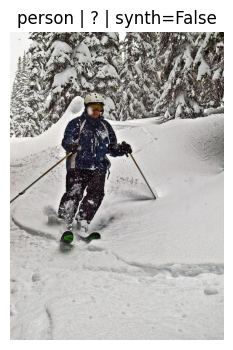

Correct: There is 1 person in the image.
Foils: There are no persons in the image.
There are 2 persons in the image.
----------------------------------------


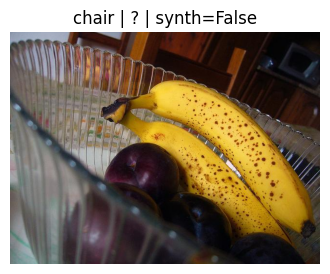

Correct: There are 2 chairs in the image.
Foils: There is 1 chair in the image.
There are 3 chairs in the image.
----------------------------------------


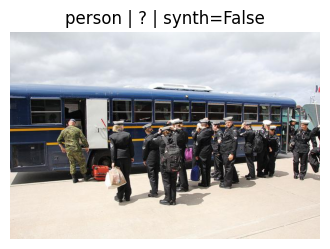

Correct: There are 12 persons in the image.
Foils: There are 11 persons in the image.
There are 13 persons in the image.
----------------------------------------


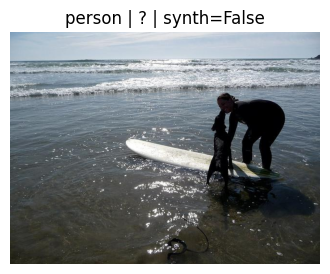

Correct: There is 1 person in the image.
Foils: There are no persons in the image.
There are 2 persons in the image.
----------------------------------------


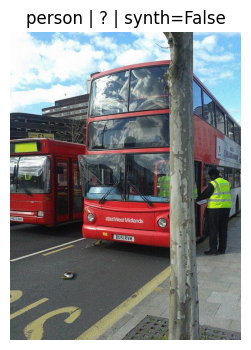

Correct: There is 1 person in the image.
Foils: There are no persons in the image.
There are 2 persons in the image.
----------------------------------------


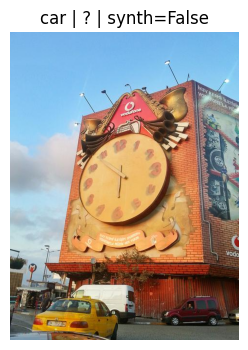

Correct: There are 4 cars in the image.
Foils: There are 3 cars in the image.
There are 5 cars in the image.
----------------------------------------


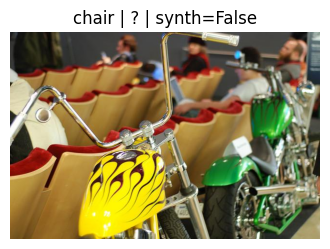

Correct: There are 14 chairs in the image.
Foils: There are 13 chairs in the image.
There are 15 chairs in the image.
----------------------------------------


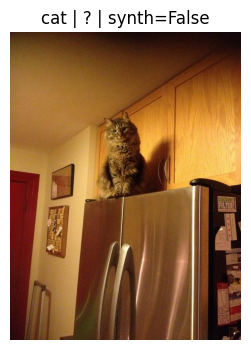

Correct: There is 1 cat in the image.
Foils: There are no cats in the image.
There are 2 cats in the image.
----------------------------------------


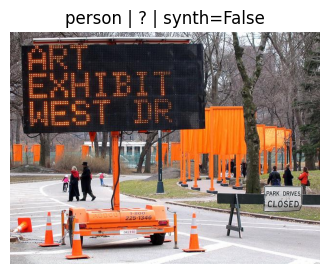

Correct: There are 10 persons in the image.
Foils: There are 9 persons in the image.
There are 11 persons in the image.
----------------------------------------


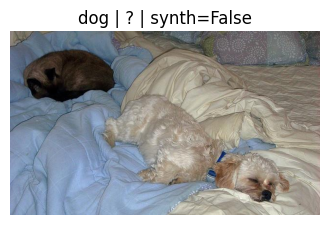

Correct: There are 2 dogs in the image.
Foils: There is 1 dog in the image.
There are 3 dogs in the image.
----------------------------------------


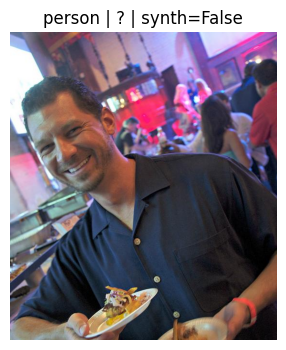

Correct: There are 8 persons in the image.
Foils: There are 7 persons in the image.
There are 9 persons in the image.
----------------------------------------


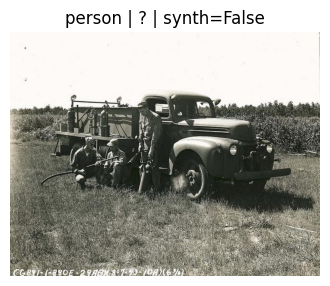

Correct: There are 3 persons in the image.
Foils: There are 2 persons in the image.
There are 4 persons in the image.
----------------------------------------


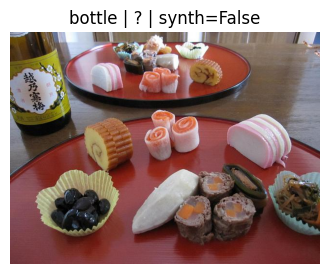

Correct: There is 1 bottle in the image.
Foils: There are no bottles in the image.
There are 2 bottles in the image.
----------------------------------------


In [48]:
# Summaries for negation and numeracy sets
def summary_from_meta(meta_path, folder):
    with open(meta_path) as f:
        data = json.load(f)
    print("Total items:", len(data))
    cnt_kw = Counter([d.get('keyword','mixed') for d in data if 'keyword' in d])
    cnt_tier = Counter([d.get('tier','unknown') for d in data if 'tier' in d])
    cnt_synth = sum(1 for d in data if d.get('synthetic', False))
    print("By keyword (top):", cnt_kw.most_common(10))
    print("By tier:", dict(cnt_tier))
    print("Synthetic crops:", cnt_synth)
    return data

neg_meta_path = os.path.join(NEG_DIR, "negation_metadata.json")
num_meta_path = os.path.join(NUM_DIR, "numeracy_metadata_fixed.json")

neg_data = summary_from_meta(neg_meta_path, NEG_DIR)
num_data = summary_from_meta(num_meta_path, NUM_DIR)

# show sample images from each set
from PIL import Image
import matplotlib.pyplot as plt
import random

def show_samples(data, folder, n=4):
    sample = random.sample(data, min(len(data), n))
    for s in sample:
        img_path = os.path.join(folder, s['file_name'])
        try:
            img = Image.open(img_path)
            plt.figure(figsize=(4,4))
            plt.imshow(img); plt.axis('off')
            title = f"{s.get('keyword','?')} | {s.get('tier','?')} | synth={s.get('synthetic', False)}"
            plt.title(title)
            plt.show()
            print("Correct:", s.get('correct_caption'))
            if s.get('task')=='numeracy':
                # print("Foils:", s.get('foils'))
                print("Foils:",end=" ")
                for foil in s.get('foils'):
                  print(foil)
            if s.get('task')=='negation':
                print("Negated:", s.get('negated_caption'))
            print("-"*40)
        except Exception as e:
            print("Error showing", s['file_name'], e)

print("\nNegation samples:")
show_samples(neg_data, NEG_DIR, n=1)
print("\nNumeracy samples:")
show_samples(num_data, NUM_DIR, n=16)


In [21]:
import os, random, json, math
from PIL import Image, ImageDraw, ImageFilter
import numpy as np

# ---------------- CONFIG ----------------
OUT_DIR = "coco_datasets/attr_binding_dataset"
N_PAIRS_REQUESTED = 75          # requested pairs -> 150 images. If diversity limited, script may reduce.
IMG_SIZE = (512, 512)
MARGIN = 40

# diversity options
SHAPES = ["cube", "sphere", "cylinder", "triangle", "star", "hexagon"]   # abstract mapping to square/circle/rounded-rect
COLORS = ["red","blue","green","yellow","purple","orange","brown","gray"]
COLOR_MAP = {
    "red":(220,50,50), "blue":(50,100,220), "green":(60,160,80), "yellow":(235,210,60),
    "purple":(150,80,200), "orange":(230,120,40), "brown":(160,100,60), "gray":(140,140,140)
}
SIZES = {"small": 56, "medium": 96, "large": 140}
SIZE_BUCKETS = list(SIZES.keys())
BG_STYLES = ["plain", "noise", "gradient"]
ROTATION_RANGE = (-15, 15)              # small rotations for realism
OVERLAP_PROB = 0.25                     # probability to allow partial overlap (harder)
SHADOW = True                           # draw soft shadow under objects
ANTIALIAS = True

# ---------------- SETUP ----------------
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

os.makedirs(OUT_DIR, exist_ok=True)

# helper drawing primitives
def draw_shape_on_layer(shape, bbox, color, rotation=0):
    """Return an RGBA image layer with the shape drawn inside bbox, possibly rotated."""
    x0,y0,x1,y1 = bbox
    w = x1 - x0
    h = y1 - y0
    layer = Image.new("RGBA", (w, h), (0,0,0,0))
    draw = ImageDraw.Draw(layer)
    outline = (30,30,30,255)
    # large stroke width scaled to object size
    stroke = max(2, int(min(w,h)/25))
    if shape == "sphere":
        draw.ellipse([0,0,w,h], fill=color+(255,), outline=outline, width=stroke)
    elif shape == "cube":
        draw.rectangle([0,0,w,h], fill=color+(255,), outline=outline, width=stroke)
        # add slight highlight strip
        strip_h = max(4, int(h*0.06))
        draw.rectangle([int(w*0.06), int(h*0.06), int(w*0.94), int(h*0.06)+strip_h], fill=(255,255,255,60))
    elif shape == "cylinder":
        # rounded-ish cylinder: rectangle + ellipse top/bottom
        draw.rectangle([0,int(h*0.12),w,int(h*0.88)], fill=color+(255,), outline=outline, width=stroke)
        draw.ellipse([0,0,w,int(h*0.24)], fill=color+(255,), outline=outline, width=stroke)
        draw.ellipse([0,int(h*0.76),w,h], fill=color+(255,), outline=outline, width=stroke)
    elif shape == "triangle":
        points = [
            (w/2, 0),
            (0, h),
            (w, h)
        ]
        draw.polygon(points, fill=color+(255,), outline=outline, width=stroke)
    elif shape == "star":
        # simple 5-point star via polar coordinates
        num_points = 5
        cx, cy = w/2, h/2
        outer_r = w/2
        inner_r = outer_r * 0.5
        pts = []
        for k in range(num_points*2):
            r = outer_r if k % 2 == 0 else inner_r
            angle = math.pi/2 + k*math.pi/num_points
            pts.append((cx + r*math.cos(angle), cy - r*math.sin(angle)))
        draw.polygon(pts, fill=color+(255,), outline=outline, width=stroke)
    elif shape == "hexagon":
        cx, cy = w/2, h/2
        r = w/2
        pts = [(cx + r*math.cos(a), cy + r*math.sin(a)) for a in np.linspace(0, 2*math.pi, 6, endpoint=False)]
        draw.polygon(pts, fill=color+(255,), outline=outline, width=stroke)
    else:
        draw.rectangle([0,0,w,h], fill=color+(255,), outline=outline, width=stroke)
    # rotate layer about center if needed
    if rotation != 0:
        layer = layer.rotate(rotation, resample=Image.BICUBIC, expand=True)
    return layer

def add_shadow(base_img, bbox, intensity=80, blur_radius=12):
    """Paint an elliptical shadow under bbox area onto base_img (in-place)."""
    x0,y0,x1,y1 = bbox
    w = x1 - x0
    h = y1 - y0
    # shadow ellipse slightly larger than bbox, offset down
    pad_w = int(w * 0.15)
    pad_h = int(h * 0.15)
    cx0 = max(0, x0 - pad_w)
    cy0 = min(base_img.height-1, y1 - int(h*0.1))
    cx1 = min(base_img.width-1, x1 + pad_w)
    cy1 = min(base_img.height-1, y1 + pad_h)
    shadow = Image.new("L", (base_img.width, base_img.height), 0)
    d = ImageDraw.Draw(shadow)
    d.ellipse([cx0, cy0, cx1, cy1], fill=intensity)
    shadow = shadow.filter(ImageFilter.GaussianBlur(radius=blur_radius))
    # composite shadow as semi-transparent dark at bottom
    base = base_img.convert("RGBA")
    shadow_col = Image.new("RGBA", base.size, (0,0,0,0))
    shadow_col.putalpha(shadow)
    # darken slightly
    base = Image.alpha_composite(base, shadow_col)
    return base.convert("RGB")

def make_background(style, size):
    w,h = size
    if style == "plain":
        # slightly off-white
        base = Image.new("RGB", size, (240,240,240))
    elif style == "noise":
        arr = np.random.normal(loc=240, scale=12, size=(h,w)).clip(0,255).astype(np.uint8)
        base = Image.fromarray(np.stack([arr,arr,arr],axis=2), "RGB")
    elif style == "gradient":
        arr = np.zeros((h,w,3), dtype=np.uint8)
        for y in range(h):
            t = y/(h-1)
            col = (int(245*(1-t)+220*t), int(245*(1-t)+230*t), int(245*(1-t)+200*t))
            arr[y,:,:] = col
        base = Image.fromarray(arr, "RGB")
    else:
        base = Image.new("RGB", size, (240,240,240))
    # tiny vignette
    base = base.filter(ImageFilter.GaussianBlur(radius=0.5))
    return base

# prepare pool of distinct (shape,color) combos
combos = [(s,c) for s in SHAPES for c in COLORS]
# ordered-pair combos where A != B in both shape or color (we only require not identical combos)
ordered_pairs = []
for i in range(len(combos)):
    for j in range(len(combos)):
        if i == j: 
            continue
        # prefer pairs with different colors OR shapes (but allow same shape diff color)
        ordered_pairs.append((combos[i], combos[j]))

random.shuffle(ordered_pairs)

# compute maximum distinct pairs available
max_pairs_available = len(ordered_pairs)
print("Available ordered pairs:", max_pairs_available)

# adjust N_PAIRS if needed
N_PAIRS = min(N_PAIRS_REQUESTED, max_pairs_available)
if N_PAIRS < N_PAIRS_REQUESTED:
    print(f"Reducing requested pairs {N_PAIRS_REQUESTED} -> {N_PAIRS} due to limited distinct combos.")

metadata = []
used_pairs = set()

pair_idx = 0
i = 0
while pair_idx < N_PAIRS and i < len(ordered_pairs):
    (sA,cA), (sB,cB) = ordered_pairs[i]
    i += 1
    # skip if this exact unordered pair (regardless of order) was used to avoid trivial repeats
    key_unordered = tuple(sorted(((sA,cA),(sB,cB))))
    if key_unordered in used_pairs:
        continue
    used_pairs.add(key_unordered)
    # randomize sizes
    sizeA = random.choice(SIZE_BUCKETS)
    sizeB = random.choice(SIZE_BUCKETS)
    szA = SIZES[sizeA]
    szB = SIZES[sizeB]
    # positions: A left, B right by default; sometimes swap positions to avoid positional bias
    swap_positions = random.random() < 0.2
    # allow overlap sometimes
    allow_overlap = random.random() < OVERLAP_PROB
    # sample background style
    bg_style = random.choice(BG_STYLES)
    # compute positions
    w,h = IMG_SIZE
    left_region = (MARGIN, int(h*0.15), int(w*0.45)-MARGIN, int(h*0.85))
    right_region = (int(w*0.55)+MARGIN, int(h*0.15), w-MARGIN, int(h*0.85))
    # helper to sample pos inside region
    def sample_pos(region, obj_sz):
        rx0, ry0, rx1, ry1 = region
        x = random.randint(rx0, max(rx0, rx1-obj_sz))
        y = random.randint(ry0, max(ry0, ry1-obj_sz))
        return x,y
    if not swap_positions:
        ax, ay = sample_pos(left_region, szA)
        bx, by = sample_pos(right_region, szB)
    else:
        bx, by = sample_pos(left_region, szB)
        ax, ay = sample_pos(right_region, szA)

    # If overlap desired, shift B closer to A randomly
    if allow_overlap:
        # move B so bounding boxes partially overlap
        overlap_offset = random.randint(-int(min(szA,szB)*0.4), int(min(szA,szB)*0.4))
        bx = max(MARGIN, min(w - szB - MARGIN, ax + int((szA - szB)/2) + overlap_offset))

    # small rotation randoms
    rotA = random.uniform(*ROTATION_RANGE)
    rotB = random.uniform(*ROTATION_RANGE)

    # build object dicts A and B
    objA = {"shape": sA, "color": cA, "size_name": sizeA, "size_px": szA, "bbox": [ax, ay, ax+szA, ay+szA], "rotation": rotA}
    objB = {"shape": sB, "color": cB, "size_name": sizeB, "size_px": szB, "bbox": [bx, by, bx+szB, by+szB], "rotation": rotB}

    # render base scene
    bg = make_background(bg_style, IMG_SIZE)
    canvas = bg.copy()
    # shadow before object if requested
    if SHADOW:
        canvas = add_shadow(canvas, objA['bbox'], intensity=90, blur_radius=10)
        canvas = add_shadow(canvas, objB['bbox'], intensity=80, blur_radius=10)

    # draw in Z-order (bigger first for mild occlusion realism)
    objs_sorted = sorted([("A",objA), ("B",objB)], key=lambda t: t[1]['size_px'], reverse=True)
    for name,o in objs_sorted:
        rgb = COLOR_MAP[o['color']]
        layer = draw_shape_on_layer(o['shape'], (0,0,o['size_px'], o['size_px']), rgb, rotation=o['rotation'])
        # compute paste coordinate (top-left)
        x0,y0,x1,y1 = o['bbox']
        # if rotated layer is larger (due to rotation), center it on bbox
        lx,ly = layer.size
        paste_x = int(x0 + (o['size_px'] - lx)/2)
        paste_y = int(y0 + (o['size_px'] - ly)/2)
        canvas.paste(layer, (paste_x, paste_y), layer)

    # optionally add tiny noise or blur to diversify
    if random.random() < 0.2:
        canvas = canvas.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.0, 0.8)))
    if random.random() < 0.15:
        # color jitter via overlay
        overlay = Image.new("RGB", IMG_SIZE, tuple(np.clip(np.random.randint(-8,8,3)+np.array((0,0,0)),0,255)))
        canvas = Image.blend(canvas, overlay, alpha=0.06)

    # save base image
    base_fname = f"attr_{pair_idx:03d}_base.png"
    base_path = os.path.join(OUT_DIR, base_fname)
    canvas.save(base_path, format="PNG")

    # create swapped scene: swap colors while keeping shapes/positions/rotations/sizes same
    objA_swap = dict(objA); objB_swap = dict(objB)
    objA_swap['color'], objB_swap['color'] = objB['color'], objA['color']

    bg2 = make_background(random.choice(BG_STYLES), IMG_SIZE)  # different background improves diversity slightly
    canvas2 = bg2.copy()
    if SHADOW:
        canvas2 = add_shadow(canvas2, objA_swap['bbox'], intensity=90, blur_radius=10)
        canvas2 = add_shadow(canvas2, objB_swap['bbox'], intensity=80, blur_radius=10)
    objs_sorted = sorted([("A",objA_swap), ("B",objB_swap)], key=lambda t: t[1]['size_px'], reverse=True)
    for name,o in objs_sorted:
        rgb = COLOR_MAP[o['color']]
        layer = draw_shape_on_layer(o['shape'], (0,0,o['size_px'], o['size_px']), rgb, rotation=o['rotation'])
        lx,ly = layer.size
        paste_x = int(o['bbox'][0] + (o['size_px'] - lx)/2)
        paste_y = int(o['bbox'][1] + (o['size_px'] - ly)/2)
        canvas2.paste(layer, (paste_x, paste_y), layer)
    # slight jitter/blur occasionally
    if random.random() < 0.2:
        canvas2 = canvas2.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.0, 0.8)))
    swap_fname = f"attr_{pair_idx:03d}_swap.png"
    swap_path = os.path.join(OUT_DIR, swap_fname)
    canvas2.save(swap_path, format="PNG")

    # canonical captions (object A then object B)
    base_caption = f"A {objA['color']} {objA['shape']} and a {objB['color']} {objB['shape']}."
    swap_caption = f"A {objA_swap['color']} {objA_swap['shape']} and a {objB_swap['color']} {objB_swap['shape']}."

    metadata.append({
        "pair_id": pair_idx,
        "base_image": base_fname,
        "swap_image": swap_fname,
        "object_A": objA,
        "object_B": objB,
        "base_caption": base_caption,
        "swap_caption": swap_caption,
        "bg_style_base": bg_style,
        "bg_style_swap": "varied"
    })

    pair_idx += 1

# Save metadata
meta_path = os.path.join(OUT_DIR, "attributes_metadata.json")
with open(meta_path, "w") as f:
    json.dump(metadata, f, indent=2)

print(f"Done. Generated {pair_idx} pairs -> {pair_idx*2} images in '{OUT_DIR}'.")
# report diversity metrics
used_color_pairs = set((m['object_A']['color'], m['object_B']['color']) for m in metadata)
used_shape_pairs = set((m['object_A']['shape'], m['object_B']['shape']) for m in metadata)
print("Unique color pairs (ordered):", len(used_color_pairs))
print("Unique shape pairs (ordered):", len(used_shape_pairs))
print("Example metadata entries (first 3):")
for m in metadata[:3]:
    print("-", m['base_image'], "->", m['base_caption'])


Available ordered pairs: 2256
Done. Generated 75 pairs -> 150 images in 'coco_datasets/attr_binding_dataset'.
Unique color pairs (ordered): 44
Unique shape pairs (ordered): 33
Example metadata entries (first 3):
- attr_000_base.png -> A gray star and a green hexagon.
- attr_001_base.png -> A green sphere and a brown sphere.
- attr_002_base.png -> A brown triangle and a gray hexagon.


In [43]:
import os
import random
import json
import math
import shutil
import numpy as np
from PIL import Image, ImageDraw, ImageFilter

# ---------------- CONFIG (Matches your original setup) ----------------
# NOTE: You will call the main function with different paths for Train/Test later
# These are just defaults or placeholders
OUT_ROOT = "coco_datasets/spatial_mcq_dataset" 
IMG_SIZE = (512, 512)
MARGIN = 36 # kept for consistency, though logic is grid-based now

# Domain choices
SHAPES = ["cube", "sphere", "cylinder", "triangle", "hexagon", "star"]
COLORS = ["red", "blue", "green", "yellow", "purple", "orange", "brown", "gray"]
COLOR_MAP = {
    "red":(220,50,50), "blue":(50,100,220), "green":(60,160,80), "yellow":(235,210,60),
    "purple":(150,80,200), "orange":(230,120,40), "brown":(160,100,60), "gray":(140,140,140)
}
# Only use clear, non-overlapping relations
RELATIONS = ["left_of", "right_of", "above", "below"]

# ---------------- HELPERS ----------------
def draw_shape(draw, shape, bbox, color):
    x0, y0, x1, y1 = bbox
    w, h = x1 - x0, y1 - y0
    outline = (30,30,30)
    stroke = 3
    
    if shape == "sphere":
        draw.ellipse(bbox, fill=color, outline=outline, width=stroke)
    elif shape == "cube":
        draw.rectangle(bbox, fill=color, outline=outline, width=stroke)
    elif shape == "cylinder":
        draw.rectangle([x0, y0+h*0.1, x1, y1-h*0.1], fill=color, outline=outline, width=stroke)
        draw.ellipse([x0, y0, x1, y0+h*0.2], fill=color, outline=outline, width=stroke)
        draw.ellipse([x0, y1-h*0.2, x1, y1], fill=color, outline=outline, width=stroke)
    elif shape == "triangle":
        draw.polygon([(x0+w/2, y0), (x0, y1), (x1, y1)], fill=color, outline=outline, width=stroke)
    elif shape == "star": 
        draw.polygon([(x0+w/2, y0), (x1, y0+h/2), (x0+w/2, y1), (x0, y0+h/2)], fill=color, outline=outline, width=stroke)
    elif shape == "hexagon":
        draw.polygon([(x0+w*0.3, y0), (x0+w*0.7, y0), (x1, y0+h/2), (x0+w*0.7, y1), (x0+w*0.3, y1), (x0, y0+h/2)], fill=color, outline=outline, width=stroke)

def create_image(objA, objB, relation):
    # Create canvas
    img = Image.new("RGB", IMG_SIZE, (240, 240, 240))
    draw = ImageDraw.Draw(img)
    
    w, h = IMG_SIZE
    sz = 100 # Fixed size for clarity
    
    # Grid Centers
    c_left = (w//4, h//2)
    c_right = (w*3//4, h//2)
    c_top = (w//2, h//4)
    c_bottom = (w//2, h*3//4)
    
    posA, posB = (0,0), (0,0)
    
    # Strict Placement Logic
    if relation == "left_of": # Note: underscore to match your original keys
        posA = (c_left[0] - sz//2, c_left[1] - sz//2)
        posB = (c_right[0] - sz//2, c_right[1] - sz//2)
    elif relation == "right_of":
        posA = (c_right[0] - sz//2, c_right[1] - sz//2)
        posB = (c_left[0] - sz//2, c_left[1] - sz//2)
    elif relation == "above":
        posA = (c_top[0] - sz//2, c_top[1] - sz//2)
        posB = (c_bottom[0] - sz//2, c_bottom[1] - sz//2)
    elif relation == "below":
        posA = (c_bottom[0] - sz//2, c_bottom[1] - sz//2)
        posB = (c_top[0] - sz//2, c_top[1] - sz//2)
        
    # Add Jitter
    jitter = 30
    posA = (posA[0] + random.randint(-jitter, jitter), posA[1] + random.randint(-jitter, jitter))
    posB = (posB[0] + random.randint(-jitter, jitter), posB[1] + random.randint(-jitter, jitter))
    
    bboxA = [posA[0], posA[1], posA[0]+sz, posA[1]+sz]
    bboxB = [posB[0], posB[1], posB[0]+sz, posB[1]+sz]
    
    # Draw
    draw_shape(draw, objA['shape'], bboxA, COLOR_MAP[objA['color']])
    draw_shape(draw, objB['shape'], bboxB, COLOR_MAP[objB['color']])
    
    return img

def get_opposite_relation(rel):
    opposites = {"left_of": "right_of", "right_of": "left_of", "above": "below", "below": "above"}
    return opposites[rel]

def rel_to_text(rel):
    return rel.replace("_", " ")

# ---------------- MAIN GENERATOR FUNCTION ----------------
def generate_spatial_dataset(output_root, n_pairs, start_seed):
    
    random.seed(start_seed)
    np.random.seed(start_seed)
    
    # Dynamic Paths
    IMG_DIR = output_root
    META_PATH = os.path.join(output_root, "spatial_metadata.json") # Kept same name
    
    if os.path.exists(IMG_DIR):
        shutil.rmtree(IMG_DIR)
    os.makedirs(IMG_DIR, exist_ok=True)
    os.makedirs(os.path.join(IMG_DIR, "images"), exist_ok=True) # Ensure images subfolder exists
    
    metadata = []
    
    for i in range(n_pairs):
        # 1. Select Objects
        shapeA, shapeB = random.sample(SHAPES, 2)
        colorA, colorB = random.sample(COLORS, 2)
        
        objA = {"shape": shapeA, "color": colorA}
        objB = {"shape": shapeB, "color": colorB}
        
        # 2. Select Relation
        relation = random.choice(RELATIONS)
        
        # 3. Create "Base" Image (True relation)
        img_base = create_image(objA, objB, relation)
        fname_base = f"sp_mcq_{i:03d}_base.png" # Matching your naming
        img_base.save(os.path.join(IMG_DIR, fname_base))
        
        # 4. Create "Swap" Image (Counterfactual relation)
        rel_swap = get_opposite_relation(relation)
        img_swap = create_image(objA, objB, rel_swap)
        fname_swap = f"sp_mcq_{i:03d}_swap.png" # Matching your naming
        img_swap.save(os.path.join(IMG_DIR, fname_swap))
        
        # 5. Generate Captions
        # Base Caption: describes the base image correctly
        cap_base = f"A {colorA} {shapeA} is {rel_to_text(relation)} a {colorB} {shapeB}."
        # Swap Caption: describes the swapped image correctly
        cap_swap = f"A {colorA} {shapeA} is {rel_to_text(rel_swap)} a {colorB} {shapeB}."
        
        # 6. Metadata Entry 1 (Base Image)
        # For the base image, cap_base is CORRECT, cap_swap is INCORRECT (Foil)
        metadata.append({
            "pair_id": i,
            "image": fname_base,
            "role": "base",
            "relation": relation,
            "options": [cap_base, cap_swap],
            "correct_index": 0, # Index 0 is correct
            "object_A": objA,
            "object_B": objB
        })
        
        # 7. Metadata Entry 2 (Swap Image)
        # For the swapped image, cap_swap is CORRECT, cap_base is INCORRECT (Foil)
        metadata.append({
            "pair_id": i,
            "image": fname_swap,
            "role": "swap",
            "relation": rel_swap,
            "options": [cap_base, cap_swap],
            "correct_index": 1, # Index 1 is correct
            "object_A": objA,
            "object_B": objB
        })
        
    with open(META_PATH, 'w') as f:
        json.dump(metadata, f, indent=2)
        
    print(f"Generated {len(metadata)} images in {output_root}")
    return len(metadata)

# --- EXECUTION (Using your paths) ---

# 1. Generate TEST Set (200 images, Seed 42)
print("--- Generating TEST Set ---")
generate_spatial_dataset(
    output_root="coco_datasets/spatial_mcq_dataset", 
    n_pairs=75, 
    start_seed=42
)

--- Generating TEST Set ---
Generated 150 images in coco_datasets/spatial_mcq_dataset


150

In [28]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [29]:
torch.cuda.is_available()

False

Total pairs: 75. Base-only entries: 75


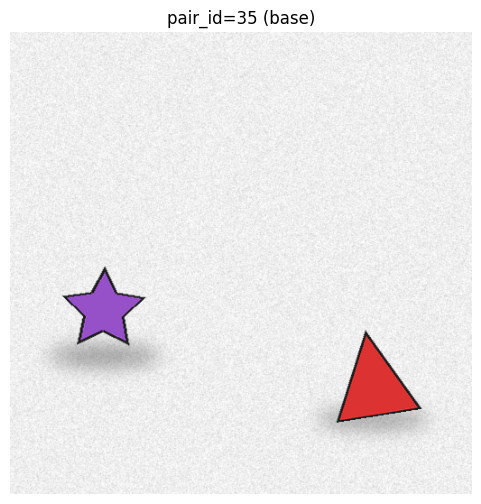

Correct caption:
   A purple star and a red triangle.

Swap / foil (not used):
   A red star and a purple triangle.

Object A: {'shape': 'star', 'color': 'purple', 'size_name': 'medium', 'size_px': 96, 'bbox': [56, 260, 152, 356], 'rotation': -1.0198779928814865}
Object B: {'shape': 'triangle', 'color': 'red', 'size_name': 'medium', 'size_px': 96, 'bbox': [353, 330, 449, 426], 'rotation': 9.08449865460063}


In [37]:
# Option 1: In-memory filter for attribute dataset (use bases only)
import os, json, random
from PIL import Image
import matplotlib.pyplot as plt

ROOT = "coco_datasets/attr_binding_dataset"
META_IN = os.path.join(ROOT, "attributes_metadata.json")
IMG_DIR = os.path.join(ROOT)  # images are saved directly in this folder

with open(META_IN, "r") as f:
    all_entries = json.load(f)

# Create list of "base-only" entries
base_entries = []
for e in all_entries:
    base_entries.append({
        "pair_id": e["pair_id"],
        "image": os.path.join("attr_binding_dataset", e["base_image"]),
        "caption": e["base_caption"],
        "swap_caption": e.get("swap_caption"),
        "object_A": e["object_A"],
        "object_B": e["object_B"],
        "bg_style": e.get("bg_style_base", None)
    })

print(f"Total pairs: {len(all_entries)}. Base-only entries: {len(base_entries)}")

def view_attr_base(index=None, random_sample=False, figsize=(6,6)):
    if random_sample:
        idx = random.randrange(len(base_entries))
    else:
        idx = 0 if index is None else index
    entry = base_entries[idx]
    img_path = entry["image"]
    if not os.path.exists(img_path):
        # try alternate path inside ROOT
        alt = os.path.join(ROOT, os.path.basename(img_path))
        if os.path.exists(alt):
            img_path = alt
        else:
            raise FileNotFoundError(f"Image not found: {entry['image']}")
    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=figsize)
    plt.imshow(img); plt.axis("off")
    plt.title(f"pair_id={entry['pair_id']} (base)")
    plt.show()
    print("Correct caption:")
    print("  ", entry["caption"])
    print("\nSwap / foil (not used):")
    print("  ", entry.get("swap_caption"))
    print("\nObject A:", entry["object_A"])
    print("Object B:", entry["object_B"])

# Example usage:
view_attr_base(random_sample=True)
# or view_attr_base(index=0)
